In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['CUDA_VISIBLE_DEVICES']='1'
    
import pandas as pd
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the tensors

In [3]:
data = torch.load('/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_t1_AD', map_location='cpu')

In [4]:
print(f"There are {data['data'].shape[0]} visits with a total of {data['data'].shape[1]*data['data'].shape[2]*data['data'].shape[3]} dimentions")

There are 3685 visits with a total of 614400 dimentions


In [5]:
caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE', 'sex', 'apoe4', 'adas13']].set_index(['participant_id','session_id'])

caps_info

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


age diagnosis  MMSE sex  apoe4  adas13
participant_id   session_id                                         
sub-ADNI002S0295 ses-M00     84.8        CN  28.0   M    1.0    4.00
                 ses-M06     85.3        CN  28.0   M    1.0    6.33
                 ses-M12     85.8        CN  30.0   M    1.0    5.67
                 ses-M24     87.0        CN  29.0   M    1.0    5.67
                 ses-M36     87.8        CN  28.0   M    1.0    6.67
...                           ...       ...   ...  ..    ...     ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0   F    0.0   11.33
                 ses-M12     75.4       NaN   NaN   F    0.0     NaN
                 ses-M24     76.4       NaN  30.0   F    0.0   15.33
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0   F    NaN   32.67
sub-ADNI941S6854 ses-M00     86.2        AD  30.0   M    NaN   27.00

[16319 rows x 6 columns]

In [6]:
caps_info['ID'] = [int(sub[-4:]) for sub in caps_info.index.get_level_values(0)]
caps_info = caps_info.set_index('ID')
caps_info = caps_info.rename(columns={'age':'TIME','diagnosis':'diag'})
caps_info

,TIME,diag,MMSE,sex,apoe4,adas13
ID,,,,,,
295,84.8,CN,28.0,M,1.0,4.00
295,85.3,CN,28.0,M,1.0,6.33
295,85.8,CN,30.0,M,1.0,5.67
295,87.0,CN,29.0,M,1.0,5.67
295,87.8,CN,28.0,M,1.0,6.67
...,...,...,...,...,...,...
6581,74.4,CN,30.0,F,0.0,11.33
6581,75.4,NaN,NaN,F,0.0,NaN
6581,76.4,NaN,30.0,F,0.0,15.33


In [7]:
RIDs = [int(sub) for sub in list(data['RID'])]

df = pd.DataFrame(index=RIDs)
df.index.name = 'ID'
df['labels'] = data['labels']
df['TIME'] = data['timepoints']
df['img_idx'] = np.arange(len(df))

In [8]:
df['ID'] = df.index
df = df.set_index(['ID', 'TIME'])
caps_info['ID'] = caps_info.index
caps_info = caps_info.set_index(['ID', 'TIME'])

In [9]:
df = df.merge(caps_info, on=['ID','TIME'])

df['ID'] = df.index.get_level_values(0)
df['TIME'] = df.index.get_level_values(1)
df = df.set_index('ID')

## Load the models

In [10]:
sys.path.append('/network/lustre/iss02/aramis/users/benoit.sautydechalon/deformetrica_MICCAI')
from deformetrica.core.model_tools.neural_networks.networks_LVAE import CVAE_3D, VAE_GAN
from deformetrica.support.utilities.general_settings import Settings

import deformetrica as dfca
from deformetrica.core.models import LongitudinalAutoEncoder
from deformetrica.LAE_experiments.fit_longitudinal_auto_encoder import *
from deformetrica.support.utilities.general_settings import Settings

In [11]:
path_CAE = 'output_AD/CVAE_longitudinal'
path_model = 'model_MRI.xml'
path_data = '/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_t1_AD'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_parameters = dfca.io.XmlParameters()
xml_parameters._read_model_xml(path_model)
Settings().dimension = 16
Settings().number_of_sources = 15
Settings().device = device
deformetrica = dfca.Deformetrica(output_dir='output', verbosity=logger.level)

Logger has been set to: NOTSET


In [12]:
#torch_data = torch.load(path_data)
image_data = Dataset(data['data'].unsqueeze(1).float(), data['labels'], data['timepoints'])
number_of_subjects = len(np.unique(image_data.labels))

model, dataset, individual_RER = instantiate_longitudinal_auto_encoder_model(logger, path_data, path_CAE=path_CAE,
                                                                    number_of_subjects=number_of_subjects, xml_parameters=xml_parameters)

Loaded 3585 train images and 100 test images
>> Loaded CAE network from output_AD/CVAE_longitudinal
Model has a total of 11535009 parameters
>> Reading 15-source initial modulation matrix from file: output_AD/LongitudinalMetricModel_modulation_matrix.txt
Setting initial onset ages from output_AD/LongitudinalMetricModel_onset_ages.txt file
Setting initial log accelerations from output_AD/LongitudinalMetricModel_log_accelerations.txt file
Initialized the Euclidean metric for latent space
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting initial sources from output_AD/LongitudinalMetricModel_sources.txt file
>> The time shift variance prior degrees of freedom parameter is set to 784
>> The log-acceleration variance prior degrees of freedom parameter is set to the number of subjects: 784
('v0', False)
('p0', False)
('reference_tim

In [13]:
v0, p0, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []

for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, modulation_matrix)
model.CAE.training = False

Tmin -22.45574951171875 Tmax 127.83348846435547 Update of the spatiotemporalframe: 3780 ms


In [14]:
ip = pd.DataFrame(index=df.index.unique() ,columns=['onset_age','log_acceleration','s1','s2','s3','s4'])

ip['onset_age'] = individual_RER['onset_age']
ip['log_acceleration'] = individual_RER['log_acceleration']
for i in range(individual_RER['sources'].shape[1]):
    ip['s'+str(i)] = individual_RER['sources'][:,i]

In [15]:
df['t_hat'] = np.exp(ip.loc[df.index]['log_acceleration']) * (df['TIME'] - ip.loc[df.index]['onset_age']) + model.get_reference_time()

## Select the images

In [28]:
eighties = df.loc[df['TIME'] == 80]
eighties = eighties[eighties['t_hat'] > 60]
eighties

,labels,img_idx,diag,MMSE,sex,apoe4,adas13,TIME,t_hat
ID,,,,,,,,,
1339,63,282,AD,24.0,F,0.0,33.67,80.0,71.214153
1282,94,428,AD,16.0,F,0.0,43.33,80.0,67.177558
30,216,994,MCI,29.0,F,0.0,22.00,80.0,66.972970
42,217,1009,AD,24.0,M,0.0,32.00,80.0,96.770352
61,218,1016,CN,28.0,F,0.0,9.67,80.0,86.391510
4501,242,1167,AD,20.0,M,1.0,35.00,80.0,76.213381
1098,330,1609,MCI,25.0,F,1.0,21.00,80.0,94.067158
4430,362,1774,MCI,24.0,M,0.0,31.00,80.0,97.018339
832,492,2360,MCI,26.0,M,1.0,28.67,80.0,72.311943


In [30]:
patients = np.arange(len(eighties))
ordered_images = []

ordered_ages = np.sort(eighties['t_hat'].iloc[patients])
for age in ordered_ages:
    ordered_images.append(int(eighties[eighties['t_hat'] == age]['img_idx']))

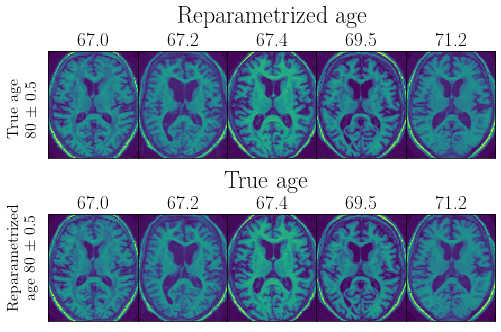

In [31]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'Computer Modern',
    'font.size':16,
})

#patients = np.arange(20)

fig, axes = plt.subplots(2, 5, figsize=(8,6))
plt.subplots_adjust(wspace=0., hspace=0.)

for i in range(5):
    #axes[i].matshow(np.rot90(data['data'][eighties['img_idx'].iloc[patients[i]]][:,:,40]))
    axes[0][i].matshow(np.rot90(data['data'][ordered_images[i]][:,:,40]))
    axes[0][i].set_title(round(ordered_ages[i],1))
    axes[1][i].matshow(np.rot90(data['data'][ordered_images[i]][:,:,40]))
    axes[1][i].set_title(round(ordered_ages[i],1))

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

fig.text(.35,.88,'Reparametrized age', fontsize=24)
fig.text(.43,.5,'True age', fontsize=24)
fig.text(0.08,.22,'Reparametrized \n age 80 $\pm$ 0.5', horizontalalignment='center', rotation=90, fontsize=16)
fig.text(0.08,.62,'True age \n 80 $ \pm$ 0.5', horizontalalignment='center', rotation=90, fontsize=16)

#plt.savefig('age_parametrization.png', dpi=300, bbox_inches='tight')
plt.show()

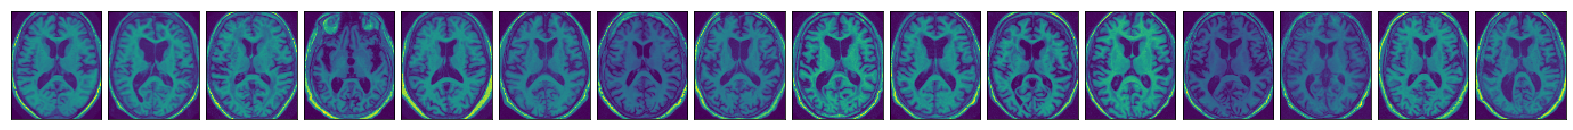

In [36]:
fig, axes = plt.subplots(1, 16, figsize=(28,2))
plt.subplots_adjust(wspace=0., hspace=0.)

for i in range(16):
    axes[i].matshow(np.rot90(data['data'][eighties['img_idx'].iloc[patients[i]]][:,:,40]))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])


In [38]:
eighties_hat = df.loc[df['t_hat'].between(79.7,80.3)]
eighties_hat

,labels,img_idx,diag,MMSE,sex,apoe4,adas13,TIME,t_hat
ID,,,,,,,,,
1074,17,95,MCI,27.0,F,0.0,17.00,91.5,79.859364
4373,21,105,AD,20.0,F,1.0,52.00,71.1,80.268840
5037,77,350,AD,23.0,M,1.0,32.00,68.3,79.920569
904,83,368,AD,25.0,M,0.0,32.00,86.2,79.890016
861,92,411,MCI,27.0,M,2.0,17.33,87.6,79.962065
...,...,...,...,...,...,...,...,...,...
423,672,3233,MCI,27.0,M,1.0,22.67,80.3,79.747961
423,672,3234,AD,23.0,M,1.0,29.67,80.8,80.221596
631,734,3489,MCI,25.0,M,1.0,39.67,77.1,79.763286


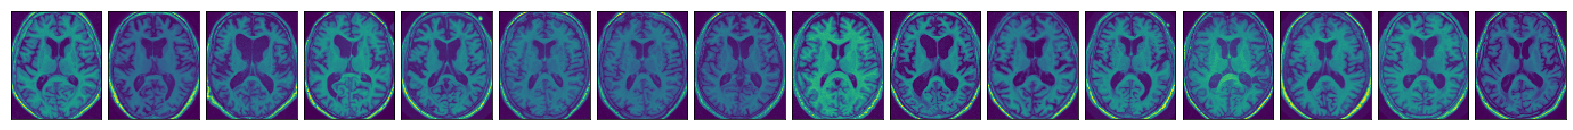

In [39]:
fig, axes = plt.subplots(1, 16, figsize=(28,2))
plt.subplots_adjust(wspace=0., hspace=0.)

for i in range(16):
    axes[i].matshow(np.rot90(data['data'][eighties_hat['img_idx'].iloc[patients[i]]][:,:,40]))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
